In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### plotting setup

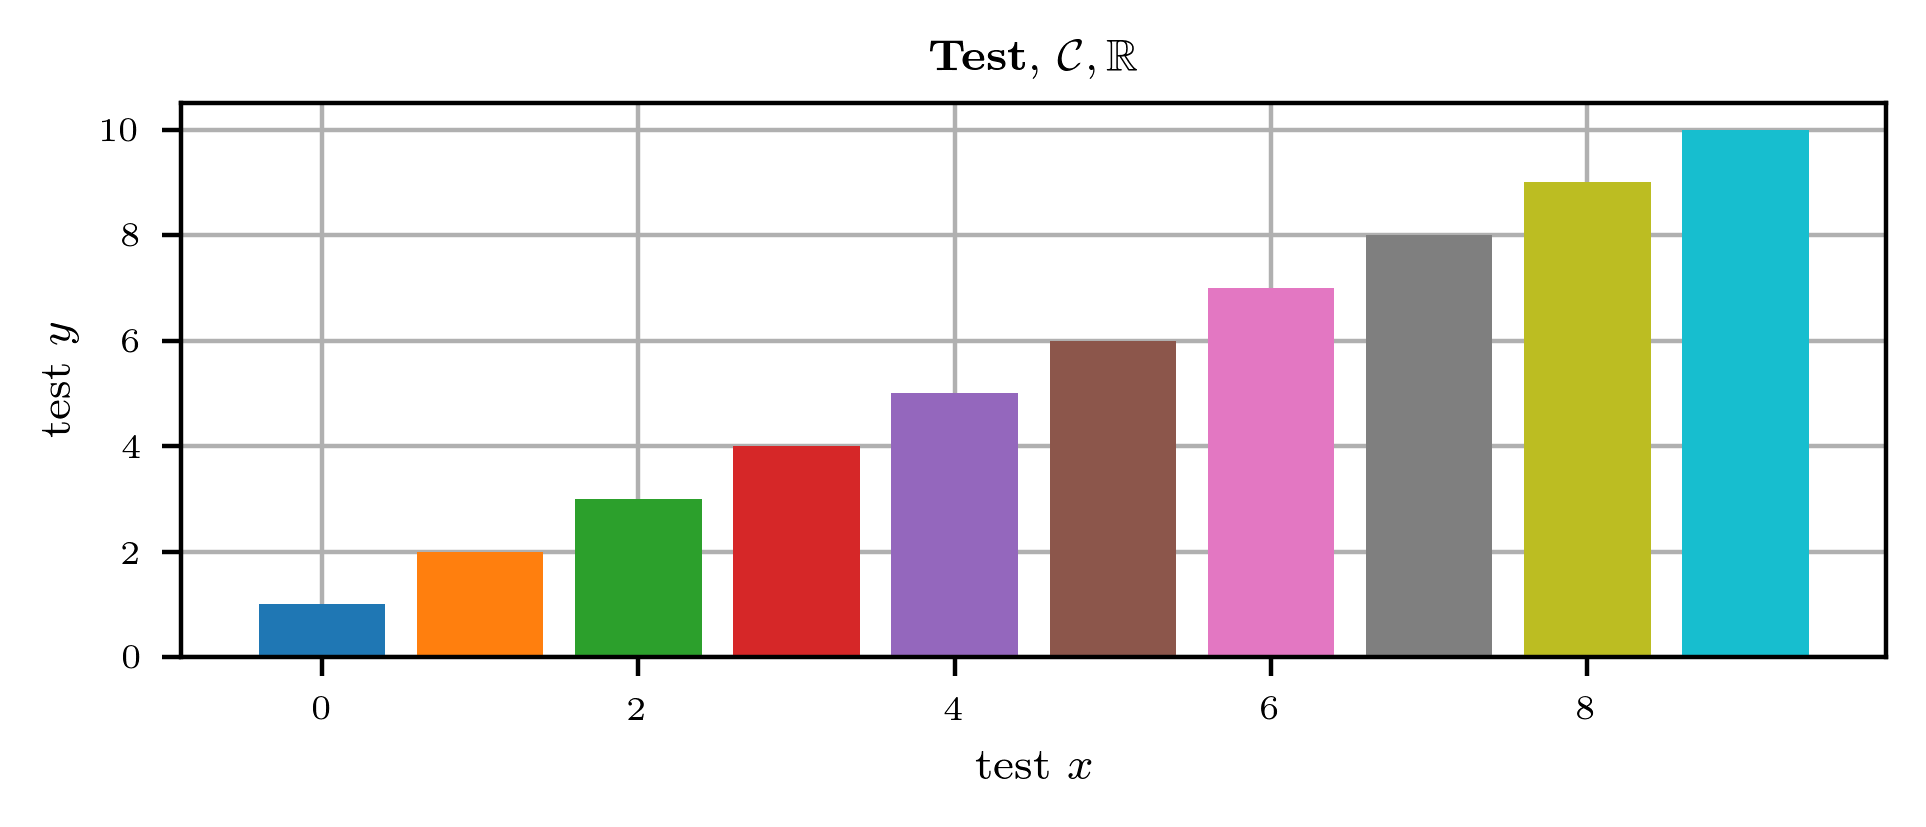

In [12]:
import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.50107  # in  --> Confirmed with template explanation

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  # figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})

# Test setup

plt.figure(dpi=400, figsize=(text_width, text_width/3))
plt.grid(0.3, zorder=0)
for i in range(10):
    plt.bar(i, i + 1, color=f'C{i}', zorder=2)
    # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
plt.title(r'\textbf{Test}, $\mathcal{C}, \mathbb{R}$')
plt.xlabel('test $x$')
plt.ylabel('test $y$')
plt.show()

# Define errorfill


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return


## package imports

In [13]:

import jax
from jax import jit, vmap
from jax import random
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scalable_gps
from scalable_gps import data
from scalable_gps.kernels import RBFKernel
from scalable_gps.models import ExactGPModel, SGDGPModel
import optax

import ml_collections



## Generate Data

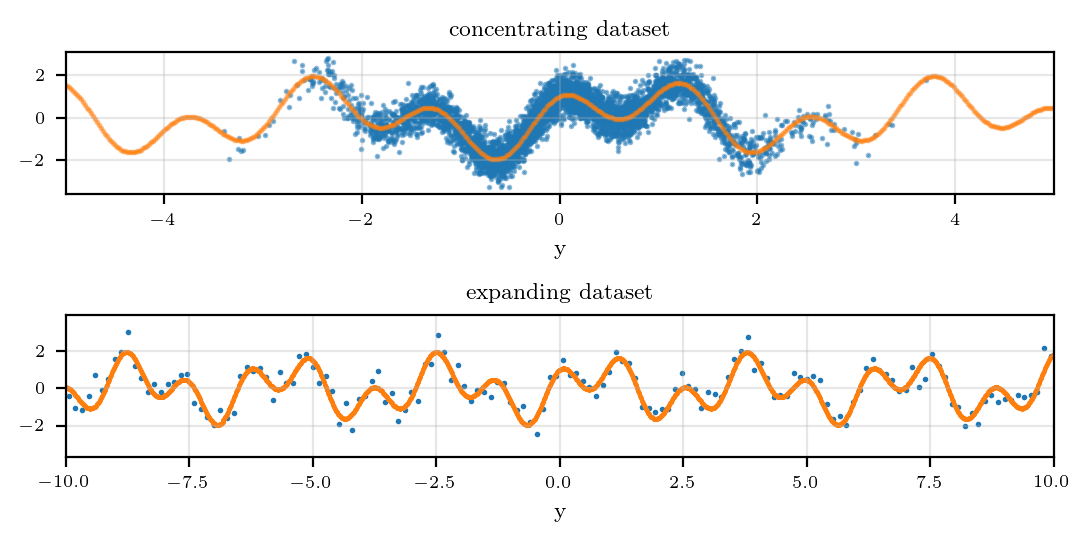

In [14]:
noise_scale = 0.5
n_data = 5000
n_test = 1000
seed = 3

concentrate_data_train, concentrate_data_test = data.get_concentrating_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    x_std = 1.0,
    normalise=False
)



spread_data_train, spread_data_test = data.get_expanding_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    n_periods = 15,
    normalise=False
)

fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  1, alpha=0.5, c=c[0])
ax[0].scatter(concentrate_data_test.x, concentrate_data_test.y,  1, alpha=0.5, c=c[1])
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-5,5])
ax[0].set_title('concentrating dataset')

ax[1].scatter(spread_data_train.x, spread_data_train.y,  1, alpha=1, c=c[0])
ax[1].scatter(spread_data_test.x, spread_data_test.y,  0.7, alpha=1, c=c[1])
ax[1].set_xlabel('x')
ax[1].set_xlabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset')

plt.tight_layout()


## hyperparams

In [15]:
concentrate_kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

spread_kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

## ExactGP fits

In [16]:


concentrate_kernel = RBFKernel(kernel_config=concentrate_kernel_config)
concentrate_exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=concentrate_kernel)
concentrate_exact_gp.compute_representer_weights(concentrate_data_train)
concentrate_exact_pred_mean = concentrate_exact_gp.predictive_mean(concentrate_data_train, concentrate_data_test)
concentrate_exact_pred_var = concentrate_exact_gp.predictive_variance(concentrate_data_train, concentrate_data_test) + noise_scale ** 2
concentrate_exact_pred_std = jnp.sqrt(concentrate_exact_pred_var)
print('concentrate_exact_pred_mean', concentrate_exact_pred_mean.shape, 'concentrate_exact_pred_var', concentrate_exact_pred_var.shape)

spread_kernel = RBFKernel(kernel_config=spread_kernel_config)
spread_exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=spread_kernel)
spread_exact_gp.compute_representer_weights(spread_data_train)
spread_exact_pred_mean = spread_exact_gp.predictive_mean(spread_data_train, spread_data_test)
spread_exact_pred_var = spread_exact_gp.predictive_variance(spread_data_train, spread_data_test) + noise_scale ** 2
spread_exact_pred_std = jnp.sqrt(spread_exact_pred_var)
print('spread_exact_pred_mean', spread_exact_pred_mean.shape, 'spread_exact_pred_var', spread_exact_pred_var.shape)



concentrate_exact_pred_mean (1000,) concentrate_exact_pred_var (1000,)
spread_exact_pred_mean (1000,) spread_exact_pred_var (1000,)


### view exact GP fits

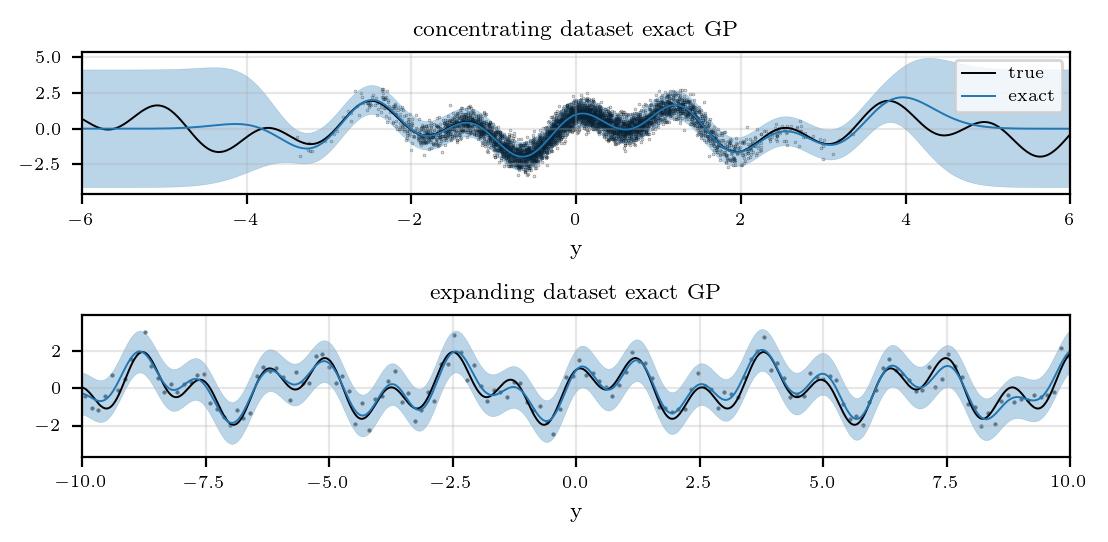

In [17]:
fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.05, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset exact GP')

ax[1].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[1].set_xlabel('x')
ax[1].set_xlabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset exact GP')

plt.tight_layout()

# VI

In [18]:
from scalable_gps.SVGP import regression_SVGP
import gpjax as gpx

## training concentrate

  0%|          | 0/5000 [00:00<?, ?it/s]

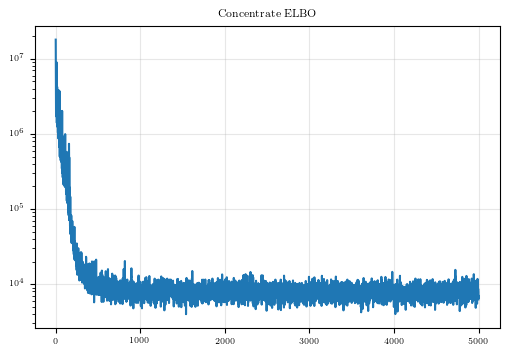

In [19]:
key = random.PRNGKey(0)

negative_elbo, init_state, D, get_predictive = regression_SVGP(
    concentrate_data_train, num_inducing=20, kernel_name = 'RBFKernel', 
    kernel_config=concentrate_kernel_config, ARD=True,
    noise_scale=noise_scale, key=key, inducing_init = "kmeans")

optimizer = optax.adam(learning_rate=0.01)
absolute_clipping = 0.5
optimizer = optax.chain(optax.zero_nans(), optax.clip_by_global_norm(absolute_clipping), optimizer)

num_iters = 5000
batch_size = 100

optimised_state = gpx.fit_batches(
    objective=negative_elbo,
    parameter_state=init_state,
    train_data=D,
    optax_optim=optimizer,
    num_iters=num_iters,
    key=key,
    batch_size=batch_size,
)

concentrate_learned_params, training_history = optimised_state.unpack()
concentrate_function_dist, concentrate_predictive_dist = get_predictive(concentrate_learned_params, concentrate_data_test.x)

plt.figure(dpi=100)
plt.plot(training_history)
plt.yscale('log')
plt.title('Concentrate ELBO')
plt.grid(alpha=0.3)


  0%|          | 0/10000 [00:00<?, ?it/s]

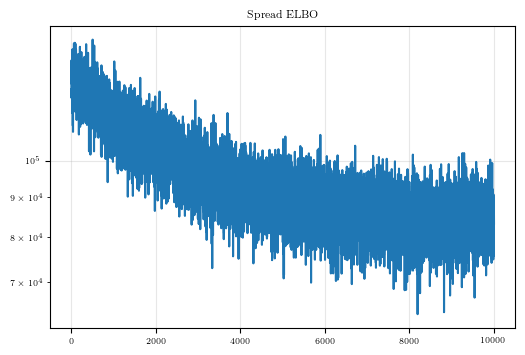

In [21]:
key = random.PRNGKey(0)

negative_elbo, init_state, D, get_predictive = regression_SVGP(
    spread_data_train, num_inducing=500, kernel_name = 'RBFKernel', 
    kernel_config=spread_kernel_config, ARD=True,
    noise_scale=noise_scale, key=key,  inducing_init ="equally_spaced")

optimizer = optax.adam(learning_rate=0.001)
absolute_clipping = 1.
optimizer = optax.chain(optax.zero_nans(), optax.clip_by_global_norm(absolute_clipping), optimizer)
num_iters = 10000

optimised_state = gpx.fit_batches(
    objective=negative_elbo,
    parameter_state=init_state,
    train_data=D,
    optax_optim=optimizer,
    num_iters=num_iters,
    key=key,
    batch_size=batch_size,
)

spread_learned_params, training_history = optimised_state.unpack()
spread_function_dist, spread_predictive_dist = get_predictive(spread_learned_params, spread_data_test.x)

plt.figure(dpi=100)
plt.plot(training_history)
plt.yscale('log')
plt.title('Spread ELBO')
plt.grid(alpha=0.3)


## predictions

Note that samples are evalauted at points and not optimisable, i.e. not in prior + representer weight form

In [22]:
num_samples = 3


concentrate_VI_mean = concentrate_predictive_dist.mean()
concentrate_VI_std  = concentrate_predictive_dist.stddev()
concentrate_VI_samples = concentrate_function_dist.sample(seed=key, sample_shape=(num_samples, ))


spread_VI_mean = spread_predictive_dist.mean()
spread_VI_std  = spread_predictive_dist.stddev()
spread_VI_samples = spread_function_dist.sample(seed=key, sample_shape=(num_samples, ))



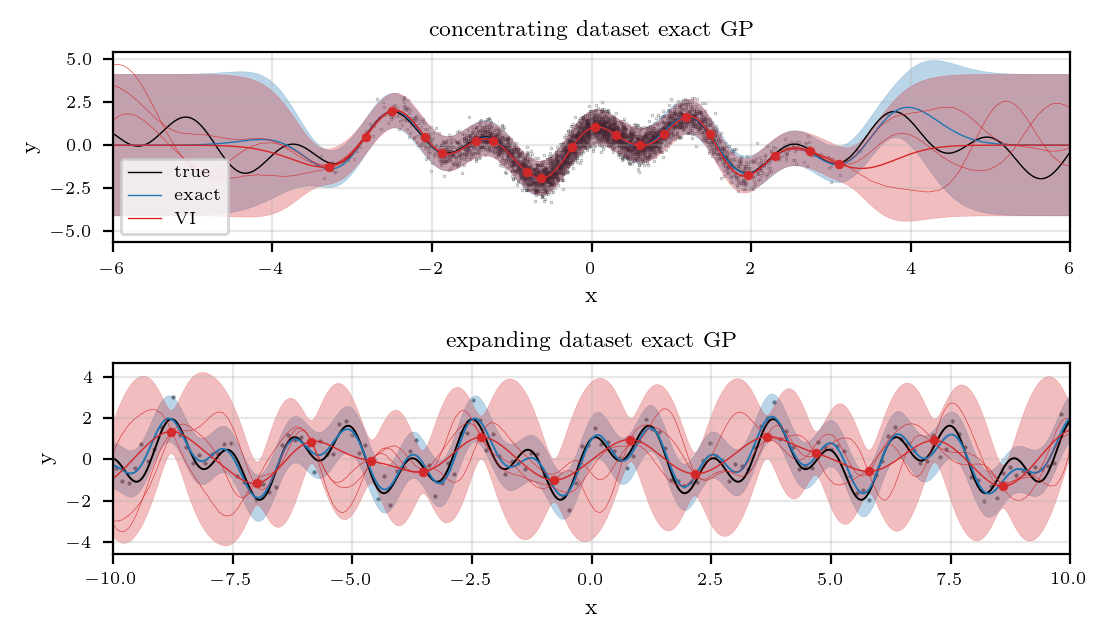

In [23]:
fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/1.7), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.03, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')


errorfill(concentrate_data_test.x.squeeze(), concentrate_VI_mean, 2*concentrate_VI_std,
          color=c[3], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='VI')

ax[0].scatter(concentrate_learned_params["variational_family"]["inducing_inputs"],
              concentrate_learned_params["variational_family"]["moments"]["variational_mean"],
             6, c=c[3], alpha=0.9, zorder=10)

ax[0].plot(concentrate_data_test.x, concentrate_VI_samples.T, alpha=1., c=c[3], linewidth=0.2)

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset exact GP')



ax[1].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')

errorfill(spread_data_test.x.squeeze(), spread_VI_mean, 2*spread_VI_std,
          color=c[3], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.5, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='VI')

ax[1].scatter(spread_learned_params["variational_family"]["inducing_inputs"],
              spread_learned_params["variational_family"]["moments"]["variational_mean"],
             6, c=c[3], alpha=0.9, zorder=10)

ax[1].plot(spread_data_test.x, spread_VI_samples.T, alpha=1., c=c[3], linewidth=0.2)

ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset exact GP')

plt.tight_layout()